In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/GiveMeSomeCredit/Data Dictionary.xls
/kaggle/input/GiveMeSomeCredit/cs-training.csv
/kaggle/input/GiveMeSomeCredit/sampleEntry.csv
/kaggle/input/GiveMeSomeCredit/cs-test.csv


In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [29]:
!pip install pandas numpy scikit-learn lightgbm scorecardpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60629 sha256=7d35209b3bd8bf093840aa85e50af561ed2779df39109a8e79529c5227c89eea
  Stored in directory: /root/.cache/pip/wheels/68/88/65/58d6aa058698c47d7a24352952ea07a1409cc2eff3a8087c0c
Successfully built scorecardpy


In [40]:
import pandas as pd
import numpy as np
import scorecardpy as sc
import lightgbm as lgb
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

df = pd.read_csv("/kaggle/input/GiveMeSomeCredit/cs-training.csv", index_col=0)
imputer = SimpleImputer(strategy="median")
df_imp = df.copy()
df_imp.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])

bins = sc.woebin(df_imp, y="SeriousDlqin2yrs", bin_num_limit=5)
df_woe = sc.woebin_ply(df_imp, bins)

X_woe = df_woe.filter(regex="_woe$")
y = df_imp["SeriousDlqin2yrs"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X_woe, y, test_size=0.2, random_state=42, stratify=y
)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "num_leaves": 31,
    "scale_pos_weight": ratio,
    "verbose": -1
}

bst = lgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dvalid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

y_val_pred = bst.predict(X_valid, num_iteration=bst.best_iteration)
print("AUC trên validation:", roc_auc_score(y_valid, y_val_pred))

df_test = pd.read_csv("/kaggle/input/GiveMeSomeCredit/cs-test.csv", index_col=0)
if 'NumberOfDependents' in df_test.columns:
    df_test = df_test.drop(columns=['NumberOfDependents'])

df_test_imp = pd.DataFrame(
    imputer.transform(df_test),
    columns=df_test.columns,
    index=df_test.index
)
df_test_woe = sc.woebin_ply(df_test_imp, bins)

X_submit = df_test_woe.filter(regex="_woe$")
X_submit = X_submit.reindex(columns=X_train.columns, fill_value=0)

y_submit_pred = bst.predict(X_submit, num_iteration=bst.best_iteration)

submission = pd.DataFrame({
    "Id": X_submit.index,
    "Probability": y_submit_pred
})
submission.to_csv("submission.csv", index=False)

[INFO] creating woe binning ...
[INFO] converting into woe values ...
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.862051	valid_1's auc: 0.860707
[200]	training's auc: 0.864524	valid_1's auc: 0.862468
[300]	training's auc: 0.866236	valid_1's auc: 0.863135
[400]	training's auc: 0.867908	valid_1's auc: 0.863446
[500]	training's auc: 0.869309	valid_1's auc: 0.863804
[600]	training's auc: 0.870386	valid_1's auc: 0.863854
Early stopping, best iteration is:
[579]	training's auc: 0.870178	valid_1's auc: 0.86387
AUC trên validation: 0.8638704186132276
[INFO] converting into woe values ...
Đã tạo file submission.csv. Bạn chỉ việc upload lên Kaggle!


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Sample index: 8652
  NumberOfTimes90DaysLate_woe: -0.1468
  age_woe: 0.2909
  MonthlyIncome_woe: 0.0207
  NumberOfTime30-59DaysPastDueNotWorse_woe: -0.1638
  DebtRatio_woe: 0.5518
  NumberOfOpenCreditLinesAndLoans_woe: -0.0684
  NumberRealEstateLoansOrLines_woe: -0.0001
  RevolvingUtilizationOfUnsecuredLines_woe: 0.9143
  NumberOfTime60-89DaysPastDueNotWorse_woe: -0.0582
  NumberOfDependents_woe: 0.0393

Sample index: 89800
  NumberOfTimes90DaysLate_woe: -0.1005
  age_woe: 0.3880
  MonthlyIncome_woe: 0.1123
  NumberOfTime30-59DaysPastDueNotWorse_woe: -0.1925
  DebtRatio_woe: -0.0985
  NumberOfOpenCreditLinesAndLoans_woe: -0.0405
  NumberRealEstateLoansOrLines_woe: 0.1338
  RevolvingUtilizationOfUnsecuredLines_woe: -0.6642
  NumberOfTime60-89DaysPastDueNotWorse_woe: -0.0478
  NumberOfDependents_woe: 0.1137

Sample index: 79094
  NumberOfTimes90DaysLate_woe: -0.1791
  age_woe: 0.1309
  MonthlyIncome_woe: -0.0142
  NumberOfTime30-59DaysPastDueNotWorse_woe: -0.2469
  DebtRatio_woe: 0.1237


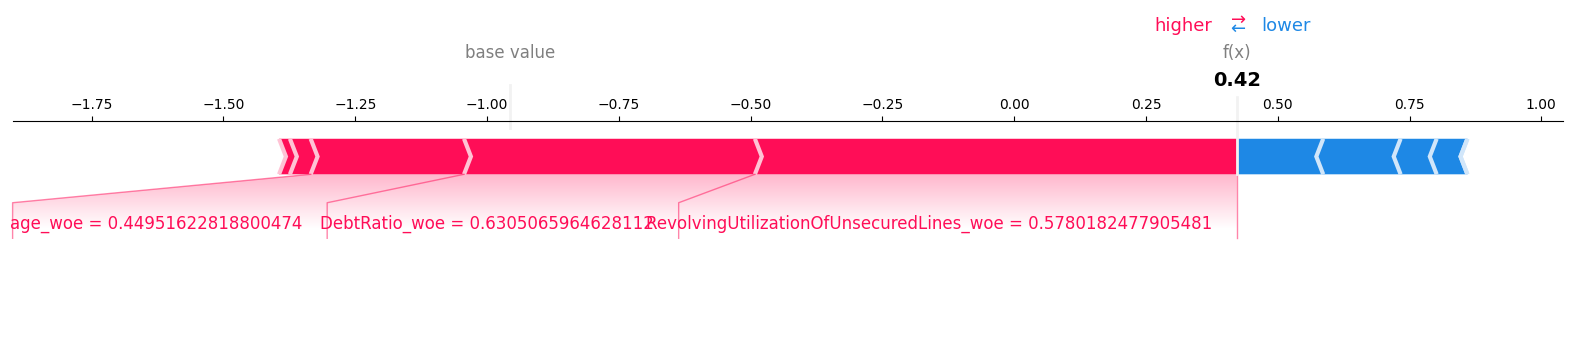

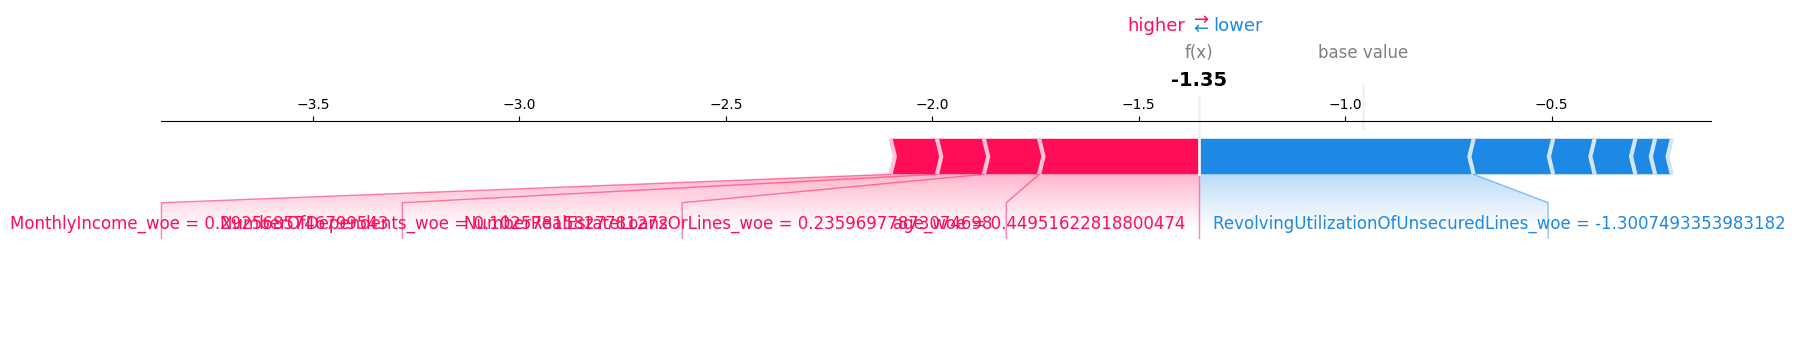

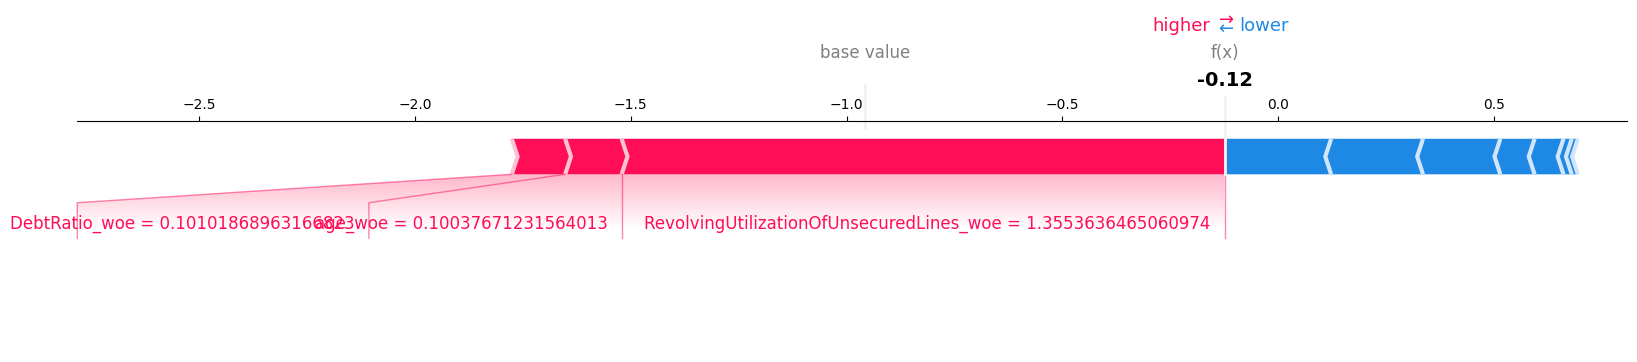

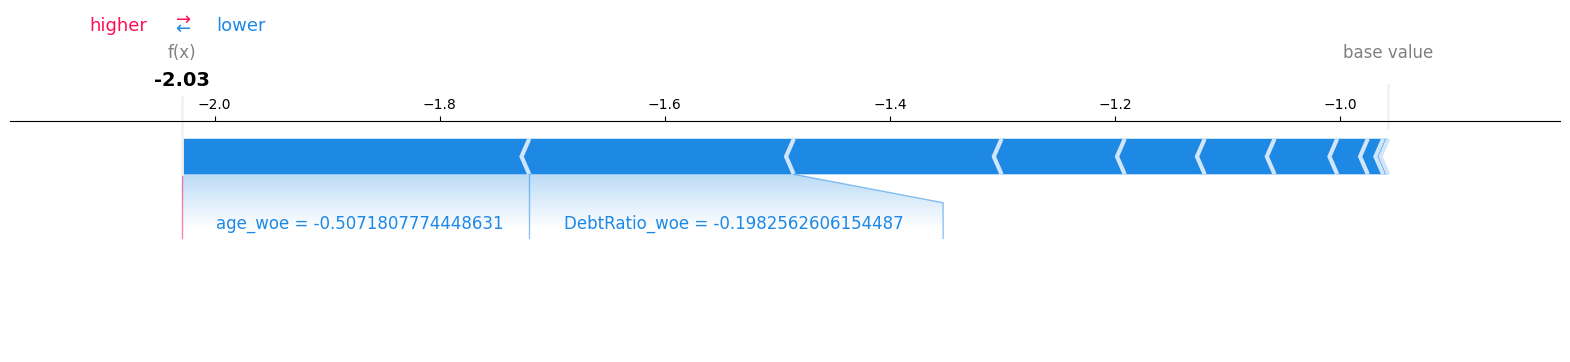

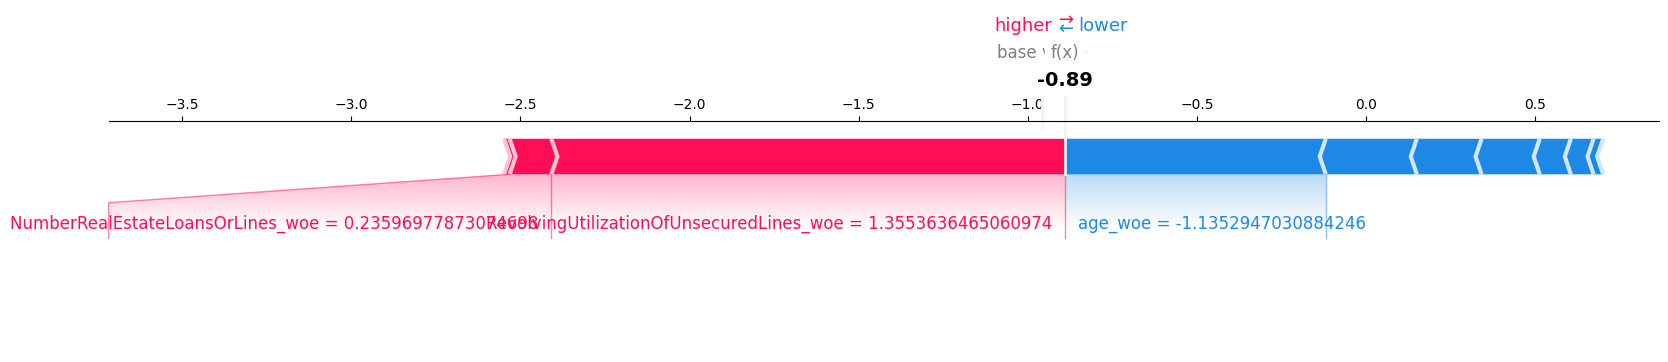

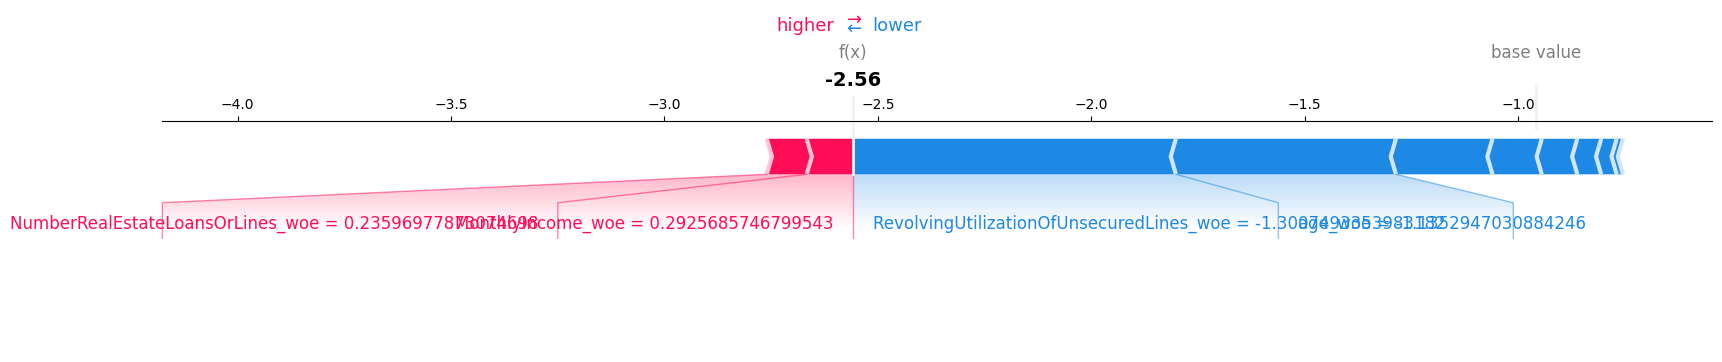

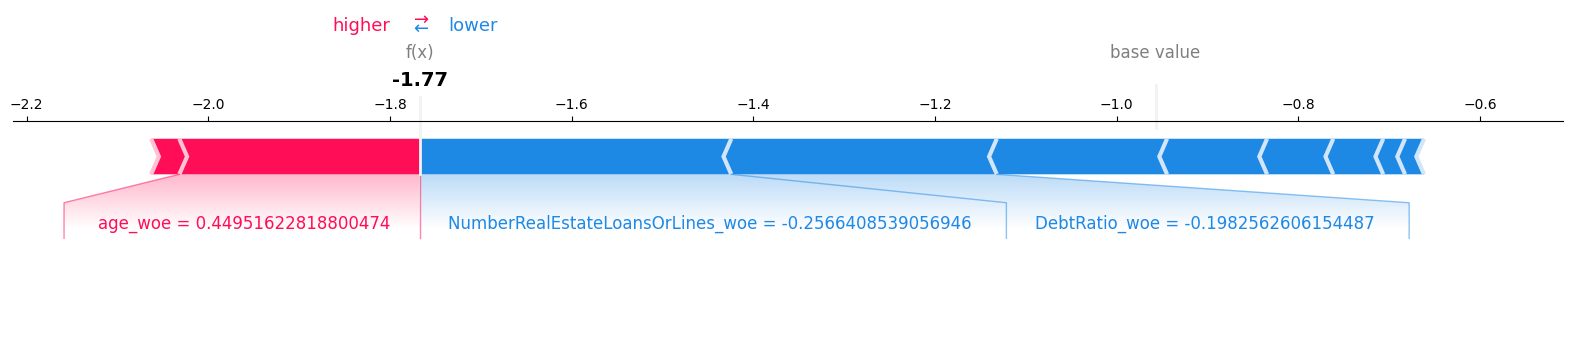

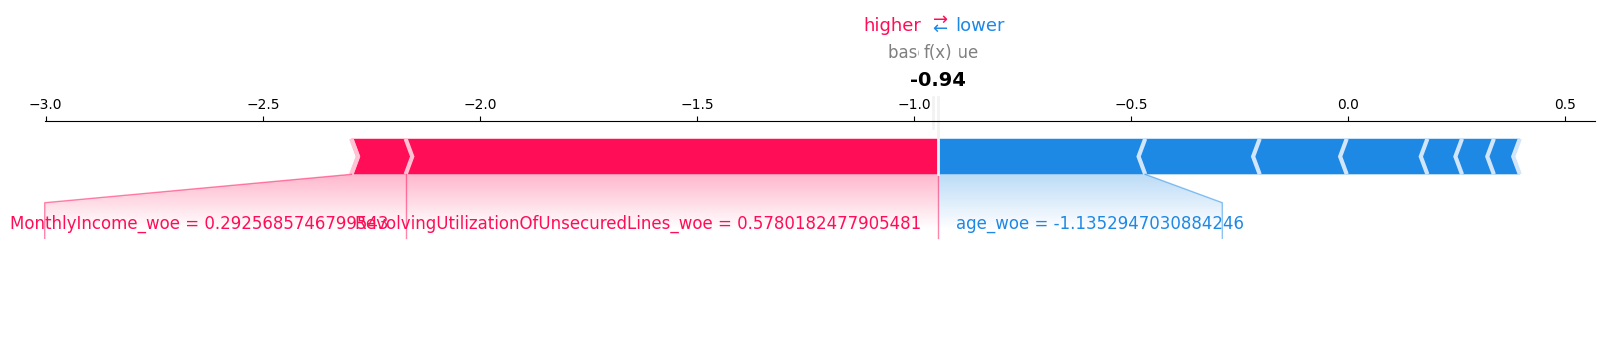

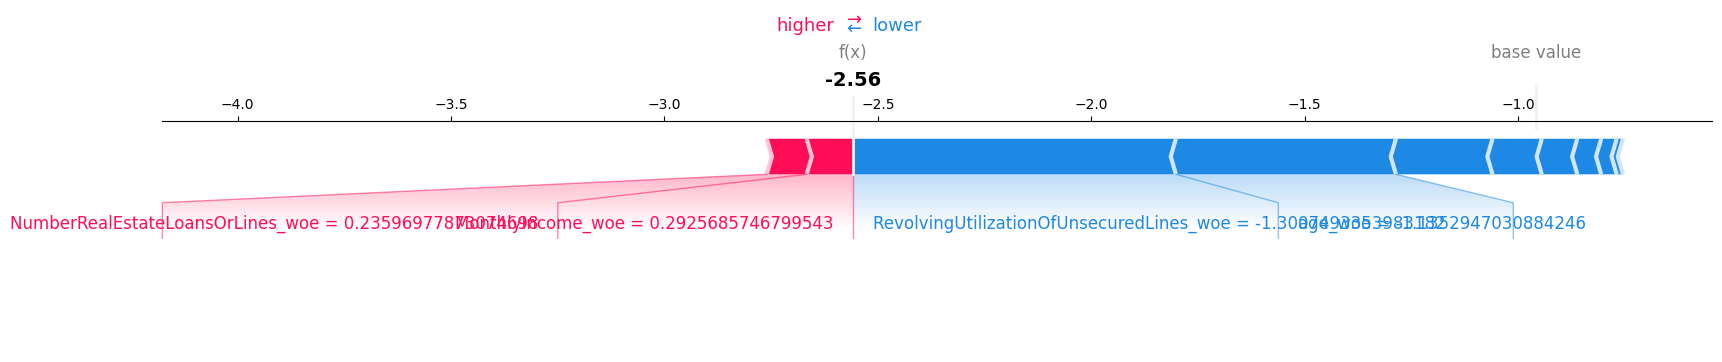

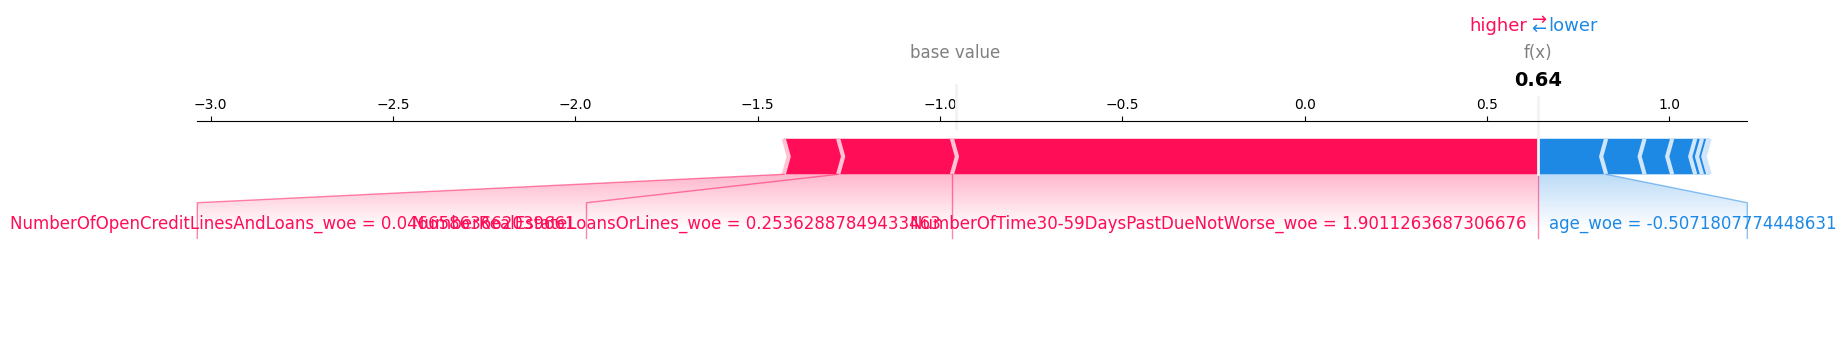

In [46]:
import shap

explainer = shap.TreeExplainer(bst)

X_sample = X_valid.iloc[20:30]

shap_vals = explainer.shap_values(X_sample)

shap_pos = shap_vals[1]

for i, idx in enumerate(X_sample.index):
    print(f"Sample index: {idx}")
    for feat, val in zip(X_sample.columns, shap_pos[i]):
        print(f"  {feat}: {val:.4f}")
    print()

import matplotlib.pyplot as plt

for i in range(10):
    shap.force_plot(
        explainer.expected_value[1],
        shap_pos[i],
        X_sample.iloc[i],
        matplotlib=True
    )
    plt.show()


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


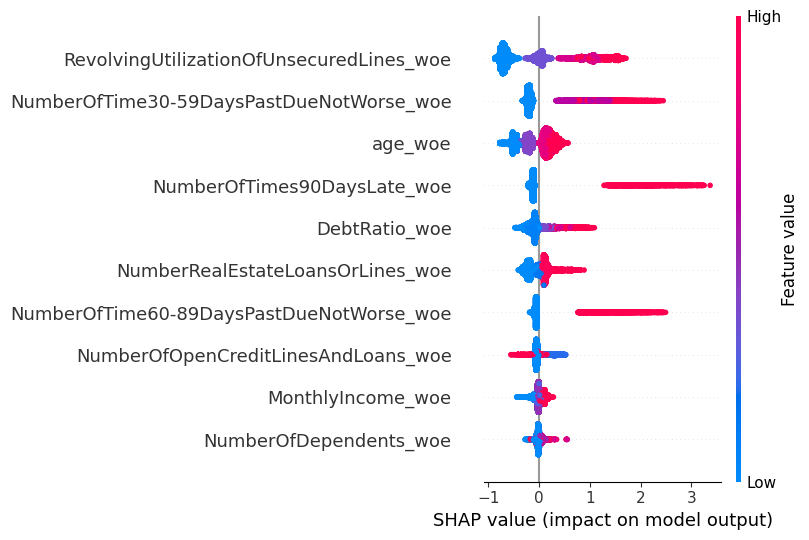

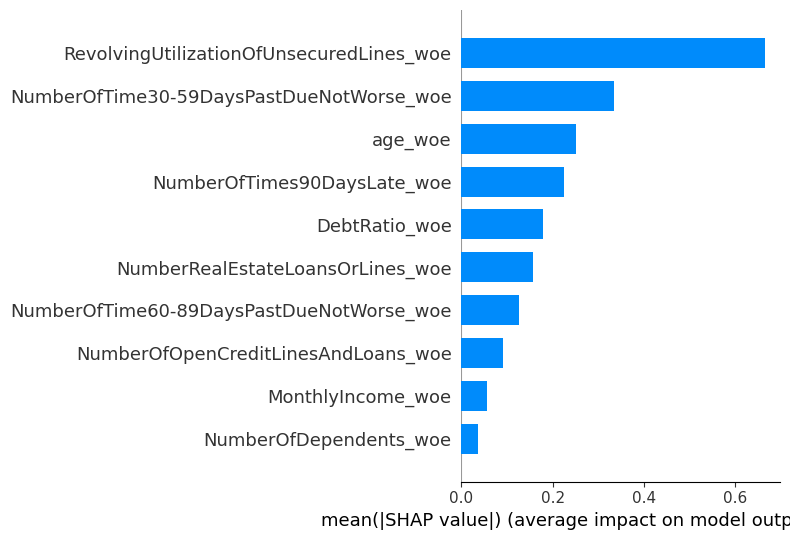

                                    feature  importance
7  RevolvingUtilizationOfUnsecuredLines_woe    0.665280
3  NumberOfTime30-59DaysPastDueNotWorse_woe    0.334998
1                                   age_woe    0.250528
0               NumberOfTimes90DaysLate_woe    0.224219
4                             DebtRatio_woe    0.178703
6          NumberRealEstateLoansOrLines_woe    0.156112
8  NumberOfTime60-89DaysPastDueNotWorse_woe    0.125385
5       NumberOfOpenCreditLinesAndLoans_woe    0.090313
2                         MonthlyIncome_woe    0.055166
9                    NumberOfDependents_woe    0.035911


In [47]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(bst)

shap_vals = explainer.shap_values(X_valid)[1]

shap.summary_plot(shap_vals, X_valid)

shap.summary_plot(shap_vals, X_valid, plot_type="bar")

shap_importance = pd.DataFrame({
    'feature': X_valid.columns,
    'importance': np.abs(shap_vals).mean(axis=0)
}).sort_values('importance', ascending=False)
print(shap_importance)
